### Imports ###

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow  as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Dropout, Flatten, Activation

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if len(tf.config.list_physical_devices('GPU')):
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

Num GPUs Available:  1


### Data loading ###

In [2]:
data_dir = os.path.join("data")
batch_size = 32 # to test
im_height, im_width = 256, 256

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, label_mode=None, image_size=(im_height, im_width), batch_size=batch_size)

Found 996 files belonging to 1 classes.


In [3]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_data = data.map(lambda x: normalization_layer(x))

# Test the normalization
images = next(iter(normalized_data))
print(images.numpy().min(), images.numpy().max())

0.0 1.0


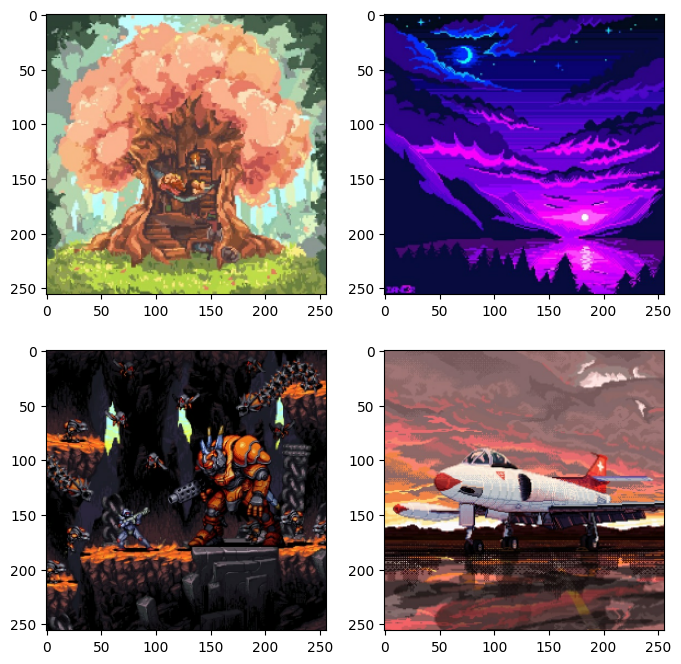

In [4]:
images = next(iter(normalized_data))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        axs[i, j].imshow(images[i*2+j])
        
plt.show()

### GAN ###

##### Generator #####

In [5]:
latent_dim = 100
g_resolution = 2

generator = Sequential()
generator.add(Dense(4*4*256, activation='relu', input_dim=latent_dim))
generator.add(Reshape((4, 4, 256)))
generator.add(UpSampling2D(size=(g_resolution, g_resolution)))
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation('relu'))
generator.add(UpSampling2D(size=(g_resolution, g_resolution)))
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation('relu'))
generator.add(UpSampling2D(size=(g_resolution*2, g_resolution*2))) # so the images are 256x256
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation('relu'))
generator.add(UpSampling2D(size=(g_resolution, g_resolution)))
generator.add(Conv2D(128, kernel_size=3, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation('relu'))
generator.add(UpSampling2D(size=(g_resolution, g_resolution)))
generator.add(Conv2D(3, kernel_size=3, padding='same'))
generator.add(Activation('tanh'))

generator.summary()

(-0.5, 255.5, 255.5, -0.5)

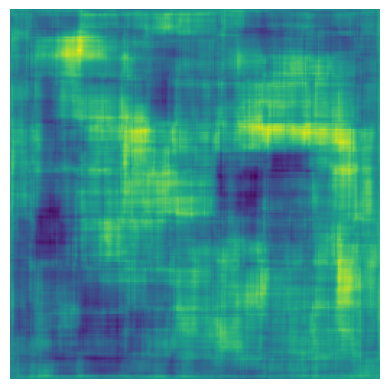

In [6]:
seed = tf.random.normal([1, latent_dim])
generated_image = generator(seed, training=False)

plt.imshow(generated_image[0, :, :, 0])
plt.axis("off")

##### Discriminator #####

In [7]:
# define discriminator
d_resolution = 256

discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(d_resolution, d_resolution, 3), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

# discriminator.summary()

In [8]:
Discriminator_Verdict = discriminator(generated_image)
print(Discriminator_Verdict)

tf.Tensor([[0.50095767]], shape=(1, 1), dtype=float32)


##### GAN class #####

In [9]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.discriminator_loss = tf.keras.metrics.Mean(name="discriminator_loss")
        self.generator_loss = tf.keras.metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [self.discriminator_loss, self.generator_loss]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.02137 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            discriminator_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            generator_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(generator_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.discriminator_loss.update_state(discriminator_loss)
        self.generator_loss.update_state(generator_loss)
        return {"discriminator_loss": self.discriminator_loss.result(), "generator_loss": self.generator_loss.result()}


### GAN Training ###

In [10]:
epochs = 200

discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

history = model.fit(normalized_data, epochs=epochs)

Epoch 1/200
32/32 [==============================] - 16s 219ms/step - d_loss: 0.6863 - g_loss: 0.7900
Epoch 2/200
32/32 [==============================] - 7s 220ms/step - d_loss: 0.7008 - g_loss: 0.6865
Epoch 3/200
32/32 [==============================] - 7s 217ms/step - d_loss: 0.6821 - g_loss: 0.7325
Epoch 4/200
32/32 [==============================] - 7s 218ms/step - d_loss: 0.6899 - g_loss: 0.7192
Epoch 5/200
32/32 [==============================] - 7s 217ms/step - d_loss: 0.6770 - g_loss: 0.7479
Epoch 6/200
32/32 [==============================] - 7s 215ms/step - d_loss: 0.6542 - g_loss: 0.7925
Epoch 7/200
32/32 [==============================] - 7s 225ms/step - d_loss: 0.6614 - g_loss: 0.8678
Epoch 8/200
32/32 [==============================] - 7s 220ms/step - d_loss: 0.6411 - g_loss: 0.8353
Epoch 9/200
32/32 [==============================] - 8s 232ms/step - d_loss: 0.5668 - g_loss: 0.9666
Epoch 10/200
32/32 [==============================] - 8s 228ms/step - d_loss: 0.5292 - g_l